## colab setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !unzip /content/drive/MyDrive/sign_language/data/3D_LSTM.zip
# !unzip /content/drive/MyDrive/sign_language/data/how2sign.zip

In [3]:
# !pip install datasets
# !pip install evaluate
# !pip install av

# vid2seq

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.io import read_video
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchview import draw_graph
import random
import numpy as np
import pandas as pd
import spacy
import datasets
import torchtext
import tqdm
import evaluate
import os
import lightning as L

In [2]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset

### testing dataset for implement model

In [4]:
# csv_path = "3D_LSTM/train.csv"
# df = pd.read_csv(csv_path)
# df.columns =  ["vi", "en"]
# for i, video_name in enumerate(df["vi"]):
#     df.loc[i, "vi"] = video_name + ".mp4"
# df.head()
# # df.to_csv("data/3D_LSTM/alaki.csv")

In [5]:
# # NOTE: (train, valid, test) data is same
# train_data, valid_data, test_data = (
#     datasets.Dataset.from_dict(df.to_dict(orient="list")),
#     datasets.Dataset.from_dict(df.to_dict(orient="list")),
#     datasets.Dataset.from_dict(df.to_dict(orient="list")),
# )

In [6]:
# train_data[0]

### main dataset

In [3]:
DATA_DIR = "./data"

In [4]:
train_csv_path = f"{DATA_DIR}/how2sign/how2sign_realigned_train.csv"
val_csv_path = f"{DATA_DIR}/how2sign/how2sign_realigned_val.csv"
test_csv_path = f"{DATA_DIR}/how2sign/how2sign_realigned_test.csv"

In [13]:
train_df = pd.read_csv(train_csv_path, delimiter="\t")
valid_df = pd.read_csv(val_csv_path, delimiter="\t")
test_df = pd.read_csv(test_csv_path, delimiter="\t")

# train_df.drop()

train_df.head()

0        --7E2sU6zP4_10-5-rgb_front
1        --7E2sU6zP4_11-5-rgb_front
2        --7E2sU6zP4_12-5-rgb_front
3        --7E2sU6zP4_13-5-rgb_front
4         --7E2sU6zP4_5-5-rgb_front
                    ...            
31160     fz6XzPxdo-0_0-5-rgb_front
31161     fz6XzPxdo-0_1-5-rgb_front
31162    fz6XzPxdo-0_17-5-rgb_front
31163     fz6XzPxdo-0_2-5-rgb_front
31164     fz6XzPxdo-0_3-5-rgb_front
Name: SENTENCE_NAME, Length: 31165, dtype: object

In [10]:
train_df = pd.DataFrame({"vi": [video+".mp4" for video in train_df["SENTENCE_NAME"]], "en": train_df["SENTENCE"]})
valid_df = pd.DataFrame({"vi": [video+".mp4" for video in valid_df["SENTENCE_NAME"]], "en": valid_df["SENTENCE"]})
test_df = pd.DataFrame({"vi": [video+".mp4" for video in test_df["SENTENCE_NAME"]], "en": test_df["SENTENCE"]})

In [6]:
train_df.head()

,vi,en
0,--7E2sU6zP4_10-5-rgb_front.mp4,And I call them decorative elements because ba...
1,--7E2sU6zP4_11-5-rgb_front.mp4,So they don't really have much of a symbolic m...
2,--7E2sU6zP4_12-5-rgb_front.mp4,"Now this is very, this is actually an insert o..."
3,--7E2sU6zP4_13-5-rgb_front.mp4,"This is all the you know, take off on the idea..."
4,--7E2sU6zP4_5-5-rgb_front.mp4,It's almost has a feathery like posture to it.


In [10]:
def not_exists_videos(df, dir_path):
    return [video for video in df['vi']
            if not os.path.exists(f"{dir_path}/{video}")]


def drop_not_exist_videos(df, dir_path):
    for video in not_exists_videos(df, dir_path):
        i = df[(df.vi == video)].index
        df = df.drop(i)
    return df

In [11]:
train_df = drop_not_exist_videos(train_df, f"{DATA_DIR}/how2sign/train/compressed_videos")
valid_df = drop_not_exist_videos(valid_df, f"{DATA_DIR}/how2sign/val/compressed_videos")
test_df = drop_not_exist_videos(test_df, f"{DATA_DIR}/how2sign/test/compressed_videos")


(
    len(not_exists_videos(train_df, f"{DATA_DIR}/how2sign/train/compressed_videos")),
    len(not_exists_videos(test_df, f"{DATA_DIR}/how2sign/test/compressed_videos")),
    len(not_exists_videos(valid_df, f"{DATA_DIR}/how2sign/val/compressed_videos")),
)

(0, 0, 0)

In [12]:
# subset selection

x_train, _, y_train, _ = train_test_split(
    list(train_df["vi"]),
    list(train_df["en"]),
    # train_size=0.22549, # 7000 sample
    # train_size=0.02255, # 700 sample
    train_size=0.00228, # 70 sample
    random_state=seed
)
x_valid, _, y_valid, _ = train_test_split(
    list(valid_df["vi"]),
    list(valid_df["en"]),
    # train_size=0.5755, # 1000 sample
    # train_size=0.0865, # 150 sample
    train_size=0.0088, # 15 sample
    random_state=seed
)
x_test, _,  y_test, _ = train_test_split(
    list(test_df["vi"]),
    list(test_df["en"]),
    # train_size=0.854, # 2000 sample
    # train_size=0.0644, # 150 sample
    train_size=0.0067, # 15 sample
    random_state=seed
)

(len(x_train), len(y_train)), (len(x_valid), len(y_valid)), (len(x_test), len(y_test))

((70, 70), (15, 15), (15, 15))

In [13]:
x_train[0], y_train[0]

('3_EsFz2QLws_3-8-rgb_front.mp4',
 "You also want to be sure that you have very comfortable socks because you're on your feet a lot.")

In [14]:
train_df = pd.DataFrame({"vi": x_train, "en": y_train})
valid_df = pd.DataFrame({"vi": x_valid, "en": y_valid})
test_df = pd.DataFrame({"vi": x_test, "en": y_test})

In [15]:
train_data = datasets.Dataset.from_dict(train_df.to_dict(orient="list"))
valid_data = datasets.Dataset.from_dict(valid_df.to_dict(orient="list"))
test_data = datasets.Dataset.from_dict(test_df.to_dict(orient="list"))

In [16]:
train_data["vi"][0], train_data["en"][0]

('3_EsFz2QLws_3-8-rgb_front.mp4',
 "You also want to be sure that you have very comfortable socks because you're on your feet a lot.")

## tokenizer

In [17]:
en_nlp = spacy.load("en_core_web_sm")

In [18]:
string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [19]:
def tokenize_example(example, en_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    return {"en_tokens": en_tokens}

In [20]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

In [21]:
train_data[17]

{'vi': '1udh8eAH5Es_4-8-rgb_front.mp4',
 'en': "I didn't seem that easy I like my method better but there it comes.",
 'en_tokens': ['<sos>',
  'i',
  'did',
  "n't",
  'seem',
  'that',
  'easy',
  'i',
  'like',
  'my',
  'method',
  'better',
  'but',
  'there',
  'it',
  'comes',
  '.',
  '<eos>']}

## Vocabularies

In [22]:
import torchtext.vocab


# min_freq = 2
min_freq = 1
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

/home/momoein/miniconda3/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/momoein/miniconda3/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [23]:
en_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', ',', 'the', '.', 'to', 'you', 'and']

In [24]:
# en_vocab.get_stoi()["name"]

In [25]:
# en_vocab["name"]

In [26]:
print(
    len(en_vocab),
    "name" in en_vocab,
    "Name" in en_vocab,
    sep="\n"
)

501
True
False


In [27]:
assert en_vocab[unk_token] == 0
assert en_vocab[pad_token] == 1

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [28]:
en_vocab.set_default_index(unk_index)

In [29]:
print(
    en_vocab["Name"],
    en_vocab.get_itos()[0],
    sep="\n"
)

0
<unk>


In [30]:
tokens = ["i", "love", "watching", "crime", "shows"]
en_vocab.lookup_indices(tokens)

[16, 0, 0, 0, 0]

In [31]:
en_vocab.lookup_tokens(en_vocab.lookup_indices(tokens))

['i', '<unk>', '<unk>', '<unk>', '<unk>']

In [32]:
def numericalize_example(example, en_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    return {"en_ids": en_ids}

In [33]:
fn_kwargs = {"en_vocab": en_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

In [34]:
print(train_data[17])
train_data[17]["en_ids"]

{'vi': '1udh8eAH5Es_4-8-rgb_front.mp4', 'en': "I didn't seem that easy I like my method better but there it comes.", 'en_tokens': ['<sos>', 'i', 'did', "n't", 'seem', 'that', 'easy', 'i', 'like', 'my', 'method', 'better', 'but', 'there', 'it', 'comes', '.', '<eos>'], 'en_ids': [2, 16, 259, 58, 421, 10, 270, 16, 33, 71, 148, 209, 55, 51, 11, 244, 6, 3]}


[2, 16, 259, 58, 421, 10, 270, 16, 33, 71, 148, 209, 55, 51, 11, 244, 6, 3]

In [35]:
data_type = "torch"
format_columns = ["en_ids"]

train_data = train_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [36]:
train_data[17]

{'en_ids': tensor([  2,  16, 259,  58, 421,  10, 270,  16,  33,  71, 148, 209,  55,  51,
          11, 244,   6,   3]),
 'vi': '1udh8eAH5Es_4-8-rgb_front.mp4',
 'en': "I didn't seem that easy I like my method better but there it comes.",
 'en_tokens': ['<sos>',
  'i',
  'did',
  "n't",
  'seem',
  'that',
  'easy',
  'i',
  'like',
  'my',
  'method',
  'better',
  'but',
  'there',
  'it',
  'comes',
  '.',
  '<eos>']}

In [37]:
type(train_data[0]["en_ids"])

torch.Tensor

## Data Loader

In [38]:
# batch = [train_data[17], train_data[18]]
# batch_en_ids = [example["en_ids"] for example in batch]

# for ids in batch_en_ids:
#     print(ids.size())

# batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=0)
# print(batch_en_ids)
# batch_en_ids.size()

In [39]:
# DIR = "/content/how2sign/train/compressed_videos"

# # batch = [train_data[17]["vi"], train_data[5]["vi"]]
# batch = [sample["vi"] for sample in train_data]
# batch_vi_ids = [
#     read_video(f"{DIR}/{example}", pts_unit="sec", output_format="TCHW")[0]
#     for example in batch
# ]

# for i, ids in enumerate(batch_vi_ids):
#     print(i, ids.size(), sep="\t")


In [40]:
# source = torch.rand((2,2))

# result = F.pad(input=source, pad=(0, 1, 0, 2), mode='constant', value=0)
# result.size(), result

In [41]:
def frame_pad_sequence_videos(batch_video):

    max_frames = max([video.size()[0] for video in batch_video])

    if max_frames % 10 != 0:
        max_frames += 10 - max_frames % 10

    pad_sizes = [max_frames - v.size()[0] for v in batch_video]

    batch_video = [
        F.pad(
            input=video,
            pad=(0,0, 0,0, 0,0, 0,pad_size), # 4D padding
            mode='constant',
            value=0
        ).view(max_frames//10, 10, 3, 224, 224)
        # view = [sequence, frames, C, H, W]
        for video, pad_size in zip(batch_video, pad_sizes)
    ]
    return batch_video

In [42]:
# [video.size()
#  for video in frame_pad_sequence_videos(batch_vi_ids)]

In [43]:
# tens = frame_pad_sequence_videos(batch_vi_ids)[0]
# print(tens.size())

In [44]:
def frames_sampling(batch_video, rate):

    for i, video in enumerate(batch_video):
        if rate > video.size()[0]:
            pad_size = rate - video.size()[0]
            batch_video[i] = F.pad(
                input=video,
                pad=(0,0, 0,0, 0,0, 0,pad_size), # 4D padding
                mode='constant',
                value=0
            )

    stops_steps = [
        (
            video.size()[0] - video.size()[0] % rate,
            video.size()[0] // rate
        )
        for video in batch_video
    ]
    sampling_idxs = [list(range(0, stop, step)) for stop, step in stops_steps]

    new_batch_video = []

    for video, idxs in zip(batch_video, sampling_idxs):
        new_video = torch.stack([video[idx] for idx in idxs])
        new_batch_video.append(new_video.view(1, rate, 3, 224, 224))

    return new_batch_video

In [45]:
# sampled_videos = frames_sampling(batch_vi_ids, 16)
# for i, video in enumerate(sampled_videos):
#   print(i, video.size(), sep="\t")

In [46]:
def get_collate_fn(pad_index, video_dir):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_vi_ids = [
            read_video(f"{video_dir}/{example['vi']}", pts_unit="sec", output_format="TCHW")[0]#[:10]
            for example in batch
        ]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_vi_ids = nn.utils.rnn.pad_sequence(
            # frame_pad_sequence_videos(batch_vi_ids),
            frames_sampling(batch_vi_ids, 10),
            batch_first=False
        ).float() / 255
        batch = {
            "en_ids": batch_en_ids,
            "vi_ids": batch_vi_ids,
        }
        return batch

    return collate_fn

In [47]:
import torch.utils
import torch.utils.data


def get_data_loader(dataset, batch_size, pad_index,video_dir, shuffle=False):
    collate_fn = get_collate_fn(pad_index, video_dir)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
        num_workers=4, ##
    )
    return data_loader

In [48]:
batch_size = 1
# video_dir = "3D_LSTM/train"
train_video_dir = f"{DATA_DIR}/how2sign/train/compressed_videos"
valid_video_dir = f"{DATA_DIR}/how2sign/val/compressed_videos"
test_video_dir = f"{DATA_DIR}/how2sign/test/compressed_videos"

train_data_loader = get_data_loader(train_data, batch_size, pad_index, train_video_dir, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index, valid_video_dir,)
test_data_loader = get_data_loader(test_data, batch_size, pad_index, test_video_dir,)

testing_train_data_loader = get_data_loader(train_data, batch_size, pad_index, train_video_dir)

In [49]:
batch = next(iter(train_data_loader))
# print(batch["vi_ids"])
# print(en_vocab.lookup_tokens(list(batch["en_ids"])))
batch["en_ids"].size(), batch["vi_ids"].size()

(torch.Size([10, 1]), torch.Size([1, 1, 10, 3, 224, 224]))

In [50]:
len(train_data_loader), len(valid_data_loader), len(test_data_loader)

(70, 15, 15)

## Building the Model

### I3D

In [51]:
from typing import Any

class ConvBlock3D(nn.Module):
    """
    Creates a convolutional layer followed by batchNorm and relu. Bias is False as batchnorm will nullify it anyways.

    Args:
        in_channels (int) : input channels of the convolutional layer
        out_channels (int) : output channels of the convolutional layer
        kernel_size (int) : filter size
        stride (int) : number of pixels that the convolutional filter moves
        padding (int) : extra zero pixels around the border which affects the size of output feature map


    Attributes:
        Layer consisting of conv->batchnorm->relu

    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: tuple | int,
            stride: tuple | int = 1,
            padding: tuple | int | str = 0,
            dilation: tuple | int = 1,
            groups: int = 1,
            bias: bool = True,
            padding_mode: str = 'zeros',
            device: Any | None = None,
            dtype: Any | None = None
        ):
        super(ConvBlock3D,self).__init__()


        self.conv3d = nn.Conv3d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
            padding_mode=padding_mode,
            device=device,
            dtype=dtype
        )

        self.batchnorm3d = nn.BatchNorm3d(out_channels)

        self.relu = nn.ReLU()

    def forward(self,x):
        return self.relu(self.batchnorm3d(self.conv3d(x)))


In [52]:
class InceptionBlock3D(nn.Module):
    '''

    building block of inception-v1 architecture. creates following 4 branches and concatenate them
    (a) branch1: 1x1 conv
    (b) branch2: 1x1 conv followed by 3x3 conv
    (c) branch3: 1x1 conv followed by 5x5 conv
    (d) branch4: Maxpool2d followed by 1x1 conv

        Note:
            1. output and input feature map height and width should remain the same. Only the channel output should change. eg. 28x28x192 -> 28x28x256
            2. To generate same height and width of output feature map as the input feature map, following should be padding for
                * 1x1 conv : p=0
                * 3x3 conv : p=1
                * 5x5 conv : p=2


    Args:
       in_channels (int) : # of input channels
       out_1x1 (int) : number of output channels for branch 1
       red_3x3 (int) : reduced 3x3 referring to output channels of 1x1 conv just before 3x3 in branch2
       out_3x3 (int) : number of output channels for branch 2
       red_5x5 (int) : reduced 5x5 referring to output channels of 1x1 conv just before 5x5 in branch3
       out_5x5 (int) : number of output channels for branch 3
       out_1x1_pooling (int) : number of output channels for branch 4

    Attributes:
        concatenated feature maps from all 4 branches constituiting output of Inception module.

    '''
    def __init__(self , in_channels , out_1x1 , red_3x3 , out_3x3 , red_5x5 , out_5x5 , out_1x1_pooling):
        super(InceptionBlock3D, self).__init__()

        # branch1 : k=1,s=1,p=0
        self.branch1 = ConvBlock3D(in_channels,out_1x1,1,1,0)

        # branch2 : k=1,s=1,p=0 -> k=3,s=1,p=1
        self.branch2 = nn.Sequential(ConvBlock3D(in_channels,red_3x3,1,1,0),ConvBlock3D(red_3x3,out_3x3,3,1,1))

        # branch3 : k=1,s=1,p=0 -> k=5,s=1,p=2
        self.branch3 = nn.Sequential(ConvBlock3D(in_channels,red_5x5,1,1,0),ConvBlock3D(red_5x5,out_5x5,5,1,2))

        # branch4 : pool(k=3,s=1,p=1) -> k=1,s=1,p=0
        self.branch4 = nn.Sequential(nn.MaxPool3d(kernel_size=3,stride=1,padding=1),ConvBlock3D(in_channels,out_1x1_pooling,1,1,0))


    def forward(self,x):

        # concatenation from dim=1 as dim=0 represents batchsize
        return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],dim=1)


In [53]:
class Inception3D(nn.Module):

    def __init__(self ,in_channels ,num_classes: int | None=None):
        super(Inception3D, self).__init__()

        self.classification = True if num_classes else False

        self.conv1 =  ConvBlock3D(in_channels, 64, 7, (1, 2, 2), 3)
        self.maxpool1 = nn.MaxPool3d(kernel_size=3, stride=(1, 2, 2), padding=1)

        self.conv2 =  nn.Sequential(ConvBlock3D(64,64,1,1,0),ConvBlock3D(64,192,3,1,1))
        self.maxpool2 = nn.MaxPool3d(kernel_size=3,stride=2,padding=1)

        # in_channels , out_1x1 , red_3x3 , out_3x3 , red_5x5 , out_5x5 , out_1x1_pooling
        self.inception3a = InceptionBlock3D(192,64,96,128,16,32,32)
        self.inception3b = InceptionBlock3D(256,128,128,192,32,96,64)
        self.maxpool3 = nn.MaxPool3d(kernel_size=3,stride=2,padding=1)

        self.inception4a = InceptionBlock3D(480,192,96,208,16,48,64)
        self.inception4b = InceptionBlock3D(512,160,112,224,24,64,64)
        self.inception4c = InceptionBlock3D(512,128,128,256,24,64,64)
        self.inception4d = InceptionBlock3D(512,112,144,288,32,64,64)
        self.inception4e = InceptionBlock3D(528,256,160,320,32,128,128)
        self.maxpool4 = nn.MaxPool3d(kernel_size=3,stride=2,padding=1)

        self.inception5a = InceptionBlock3D(832,256,160,320,32,128,128)
        self.inception5b = InceptionBlock3D(832,384,192,384,48,128,128)

        self.avgpool = nn.AvgPool3d(kernel_size=(1, 7, 7) , stride=1)
        self.dropout = nn.Dropout(p=0.4)

        if self.classification:
            self.fc1 = nn.Linear( 1024 , num_classes)


    def forward(self,x):

        x = self.conv1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)

        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)

        if self.classification:
            x = self.fc1(x)

        return x


### Encoder

In [54]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.cnn = Inception3D(in_channels) # output_size = 1024
        self.rnn = nn.LSTM(1024, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size, in_channels (frames), C, H, W]
        src_length = src.size()[0]

        cnn_outputs = []
        for i in range(src_length):
            input = src[i]
            out = self.dropout(self.cnn(input))
            cnn_outputs.append(out)

        cnn_outputs = torch.stack(cnn_outputs)
        # cnn outputs = [src length, batch size, embedding dim]

        outputs, (hidden, cell) = self.rnn(cnn_outputs)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

### Decoder

In [57]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell


### vid2seq

In [58]:
class Vid2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        # self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size, frames, C, H, W]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = []

        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        # input = [batch size]
        for t in range(0, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]

            outputs.append(output)

            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]

        outputs = torch.stack(outputs)
        return outputs


In [59]:

class LightVid2Seq(L.LightningModule):

    def __init__(self, encoder, decoder, pad_index, teacher_forcing_ratio, clip) -> None:
        super().__init__()

        self.model = Vid2Seq(encoder, decoder)

        self.criterion = nn.CrossEntropyLoss(ignore_index=pad_index)
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.clip = clip

    def forward(self, input):
        return self.model(input)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        src = batch["vi_ids"]
        trg = batch["en_ids"]
        # src = [src length, batch size, ...]
        # trg = [trg length, batch size]
        output = self.model(src, trg, self.teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = self.criterion(output, trg)
        self.log("train_loss", loss)
        return loss
    
    def backward(self, loss) -> None:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)
    
    def valid_test_step(self, batch, batch_idx):
        src = batch["vi_ids"]
        trg = batch["en_ids"]
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        output = self.model(src, trg, 0)  # turn off teacher forcing
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = self.criterion(output, trg)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.valid_test_step(batch, batch_idx)
        self.log("valid_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss = self.valid_test_step(batch, batch_idx)
        self.log("test_loss", loss)
        return loss

## Training The Model

In [61]:
input_dim = 10
output_dim = len(en_vocab)
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5

encoder = Encoder(
    input_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

pad_index = pad_index
teacher_forcing_ratio = 0.9
clip = 1.0

model = LightVid2Seq(encoder, decoder, pad_index, teacher_forcing_ratio, clip)

### model graph

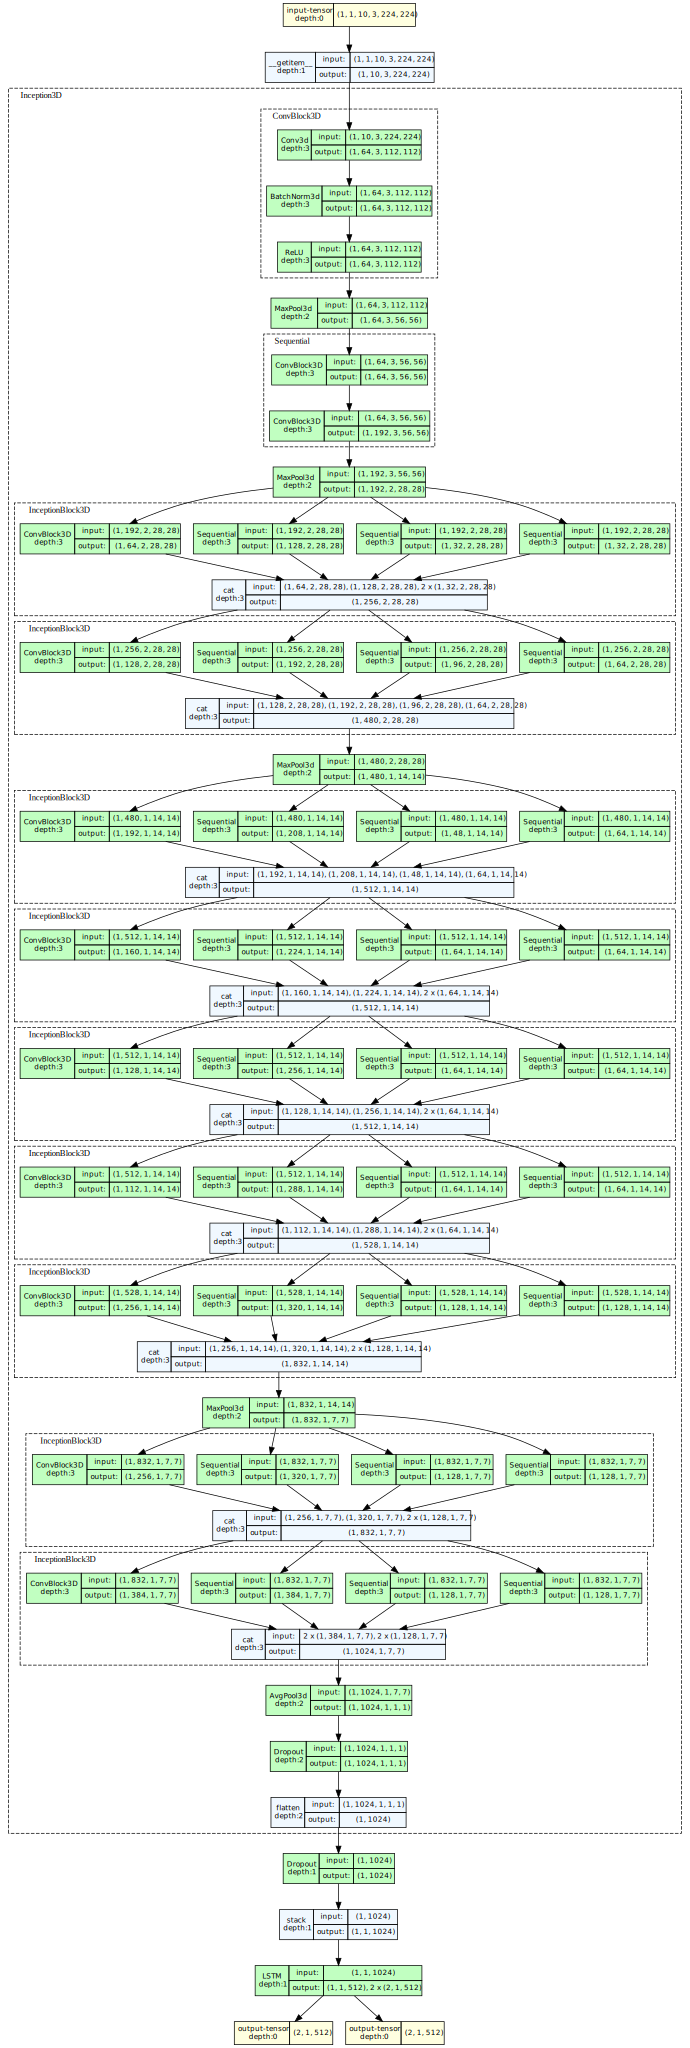

In [80]:
# architecture = 'Encoder'
# model_graph = draw_graph(
#     model=encoder, 
#     input_size=next(iter(train_data_loader))["vi_ids"].size(), 
#     roll=True, 
#     expand_nested=True, 
#     graph_name=f'self_{architecture}', 
#     # save_graph=True,
#     filename=f'img/self_{architecture}',
# )
# model_graph.visual_graph

In [77]:
# architecture = 'Dencoder'
# model_graph = draw_graph(
#     model=decoder, 
#     input_size=[(batch_size,), (n_layers, batch_size, hidden_dim), (n_layers, batch_size, hidden_dim)], 
#     roll=True, 
#     expand_nested=True, 
#     graph_name=f'self_{architecture}', 
#     save_graph=False,
#     filename=f'self_{architecture}',
# )
# model_graph.visual_graph

RuntimeError: Failed to run torchgraph see error message

### Weight Initialization

In [61]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

LightVid2Seq(
  (model): Vid2Seq(
    (encoder): Encoder(
      (cnn): Inception3D(
        (conv1): ConvBlock3D(
          (conv3d): Conv3d(10, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3))
          (batchnorm3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
        (maxpool1): MaxPool3d(kernel_size=3, stride=(1, 2, 2), padding=1, dilation=1, ceil_mode=False)
        (conv2): Sequential(
          (0): ConvBlock3D(
            (conv3d): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
            (batchnorm3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU()
          )
          (1): ConvBlock3D(
            (conv3d): Conv3d(64, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (batchnorm3d): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU()
      

In [62]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 24,095,941 trainable parameters


### Model Training

In [66]:
trainer = L.Trainer(max_epochs=1, log_every_n_steps=1, default_root_dir="model/")

best_model_path = trainer.checkpoint_callback.best_model_path
if best_model_path == "":
    best_model_path = None

trainer.fit(model, train_data_loader, valid_data_loader, ckpt_path=best_model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-07-28 21:17:43.182730: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-28 21:17:43.219006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-28 21:17:43.915474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/momoein/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 11. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/momoein/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 15. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/momoein/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 12. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/momoein/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 28. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/momoein/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9. To avoid any miscalculation

In [64]:
trainer.test(model, test_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/momoein/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/home/momoein/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 40. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/momoein/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 36. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/momoein/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/momoein/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculation

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5.711165428161621     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.711165428161621}]

## Evaluating the Model

The first thing to do is to test the model's performance on the test set.

We'll load the parameters (`state_dict`) that gave our model the best validation loss and run it on the test set to get our test loss and perplexity.


In [71]:
path_to_best_checkpoint = trainer.checkpoint_callback.best_model_path

test_loss = trainer.test(model, test_data_loader, ckpt_path=path_to_best_checkpoint)[0]["test_loss"]

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

Restoring states from the checkpoint path at model/lightning_logs/version_0/checkpoints/epoch=0-step=70.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at model/lightning_logs/version_0/checkpoints/epoch=0-step=70.ckpt
/home/momoein/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5.711165904998779     │
└───────────────────────────┴───────────────────────────┘

| Test Loss: 5.711 | Test PPL: 302.223 |


In [80]:
def translate_video(
    video,
    model,
    en_nlp,
    en_vocab,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        hidden, cell = model.encoder(video)
        inputs = en_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        tokens = en_vocab.lookup_tokens(inputs)
    return tokens

In [81]:
video = next(iter(test_data_loader))["vi_ids"].to(device)
expected_translation = test_data[0]["en"]

# print(len([token.text for token in en_nlp.tokenizer(expected_translation)]))
video.size(), expected_translation

(torch.Size([1, 1, 10, 3, 224, 224]), 'The nasal cavity is fairly flexible.')

In [82]:
translation = translate_video(
    video,
    model,
    en_nlp,
    en_vocab,
    sos_token,
    eos_token,
    device,
)

In [83]:
translation

['<sos>',
 'now',
 'now',
 'the',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 '<eos>']

In [84]:
translations = [
    translate_video(
        example["vi_ids"].to(device),
        model,
        en_nlp,
        en_vocab,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(testing_train_data_loader) ### raplace with test_data_loader
]

100%|██████████| 70/70 [00:24<00:00,  2.90it/s]


In [85]:
for i, translate in enumerate(translations):
    print(translate)
    if 5 < i:
        break

['<sos>', 'now', 'now', 'the', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', '<eos>']
['<sos>', 'now', 'now', 'the', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', '<eos>']
['<sos>', 'now', 'now', 'the', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', '<eos>']
['<sos>', 'now', 'now', 'the', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', '<eos>']
['<sos>', 'now', 'now', 'the', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', '<eos>']
['<sos>', 'now', 'now', 'the', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', '<eos>']
['<sos>', 'now', 'now', 'the', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', '<eos>']


In [86]:
bleu = evaluate.load("bleu")

In [87]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in train_data] ### raplace with test_data

predictions[0], references[0]

('now now the , , , , , , , , , , , , , , , , , , , ,',
 ["You also want to be sure that you have very comfortable socks because you're on your feet a lot."])

In [88]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [89]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [90]:
print(
    tokenizer_fn(predictions[0]),
    tokenizer_fn(references[0][0]),
    sep="\n",
)

['now', 'now', 'the', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',']
['you', 'also', 'want', 'to', 'be', 'sure', 'that', 'you', 'have', 'very', 'comfortable', 'socks', 'because', 'you', "'re", 'on', 'your', 'feet', 'a', 'lot', '.']


In [91]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [92]:
results

{'bleu': 0.0,
 'precisions': [0.07080745341614907, 0.0, 0.0, 0.0],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0274409700063816,
 'translation_length': 1610,
 'reference_length': 1567}